In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from WISE_tools import plot_confusion_matrix

%matplotlib inline

/Users/carina/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/carina/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/carina/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined),joined.columns

(6484,
 Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
        'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
        'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
        'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
        'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
        'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
        'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
        'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'Unnamed: 0_x',
        'CommonName_y', 'Class', 'CoarseClass', 'IsBinary', 'Unnamed: 0_y',
        'WISE_Designation_x', 'N_obs', 'W1chi2', 'W1chi2red', 'W1_MAD',
        'W1_EWM', 'W2chi2', 'W2chi2red', 'W2_MAD', 'W2_EWM', 'W1-W2chi2',
        'W1-W2chi2red', 'W1-W2_MAD', 'W1-W2_EWM', 'Unnamed: 0',
        'WISE_Designation_y', 'N_visits', 'W1_Nzeroes', 'W1_meanDt', 'W1_stdDt',
        'W2_Nzeroes', 'W2_

In [3]:
training_indices = np.array([c not in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class'].values]) & np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

In [4]:
#Our features will be color and G/W1 magnitude.
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1chi2red','W2chi2red','W1-W2chi2red',
                   'W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes','W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt',
                   'W2_stdDt','W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt']]
scaler=StandardScaler()
X_scale = scaler.fit_transform(X)
y = training_data['Class'].values
y_c = training_data['CoarseClass'].values
encoder = LabelEncoder()
encoder_c = LabelEncoder()
y_num = encoder.fit_transform(y)
y_num_c = encoder_c.fit_transform(y_c)

In [7]:
gpc = GaussianProcessClassifier(n_jobs=-1)
gpc_c = GaussianProcessClassifier(n_jobs=-1)

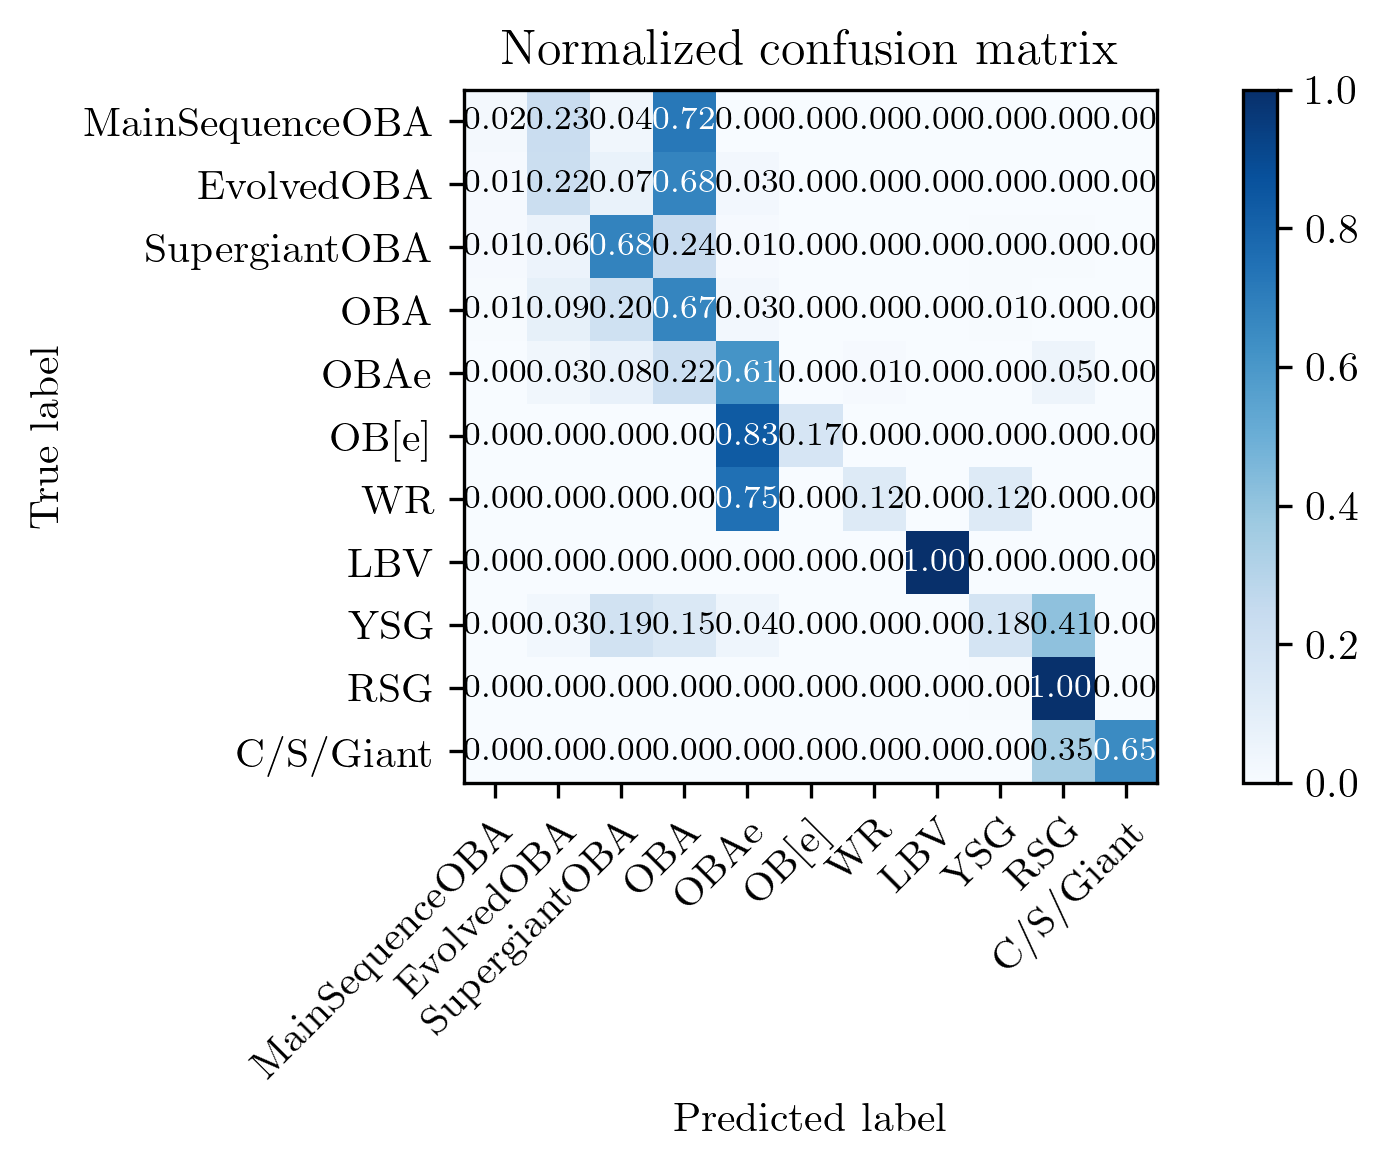

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y_num, test_size=0.3, random_state=0)

gpc.fit(X_train,y_train)
y_check_GP = encoder.inverse_transform(gpc.predict(X_test))

classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBA','OBAe','OB[e]','WR','LBV','YSG',
                   'RSG','C/S/Giant']

fig,ax = plot_confusion_matrix(encoder.inverse_transform(y_test), y_check_GP, classes=classes, normalize=True);
fig.dpi = 300
plt.tight_layout()
plt.savefig('confusion_GP.pdf');

(0.5, 5000)

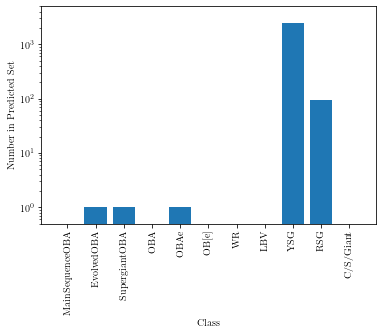

In [11]:
unknown_indices = [c in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class']]
unknowns = joined[unknown_indices].fillna(value=0)
unknowns_data = unknowns[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1',
                          'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM',
                          'W1-W2_EWM','W1_Nzeroes','W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 
                          'W2_meanDt', 'W2_stdDt','W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt']]
X_unknown = scaler.transform(unknowns_data)
unknown_classes = encoder.inverse_transform(gpc.predict(unknowns_data))
num_output = []
for pred_class in classes:
    num = len(unknown_classes[unknown_classes == pred_class])
    num_output.append(num)
plt.bar(np.arange(len(classes)),num_output)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(classes)),labels=classes,rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Number in Predicted Set')
plt.ylim(0.5,5000)

# How does this perform with very coarse labels?

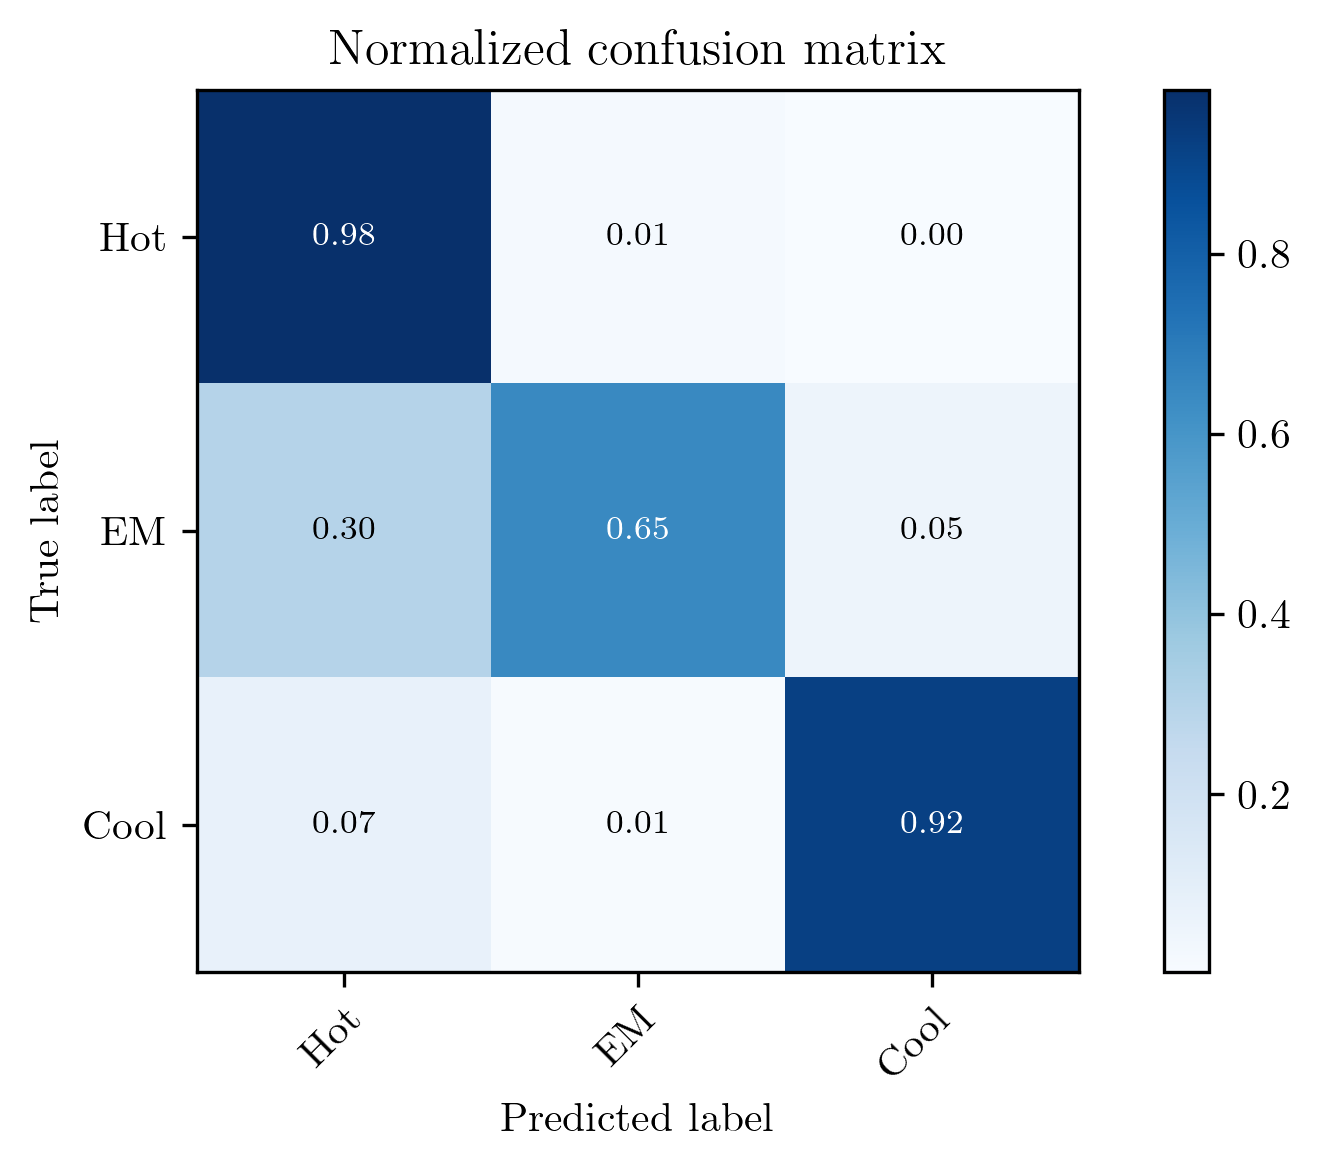

In [12]:
X_train, X_test, y_train_c, y_test_c = train_test_split(
    X_scale, y_num_c, test_size=0.3, random_state=0)

gpc_c.fit(X_train,y_train_c)
y_check_GP_c = encoder_c.inverse_transform(gpc_c.predict(X_test))

classes_c = ['Hot','EM','Cool']

fig,ax = plot_confusion_matrix(encoder_c.inverse_transform(y_test_c), y_check_GP_c, classes=classes_c, normalize=True);
fig.dpi = 300
plt.tight_layout()
plt.savefig('confusion_GP_coarse.pdf');